# Imports, Custom Functions & Data Loading

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict
from transformers import AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

## Define functions

In [2]:
def read_csv(filename):
    return pd.read_csv(filename, sep=',', encoding='utf-8', index_col=0).iloc[:, -2:].reset_index(drop=True)


def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# The sequences being in the formar ['word1', 'word2', 'word3', ...], preprocess it
def string2embedding_idx(text_sequence, model):

    sequence = []
    for token in text_sequence:
        try:
            sequence.append(model.wv.key_to_index[token])
        except:
            pass

    return sequence


def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


'''# Create a torch dataset class for the training data
class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.Tensor(self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]).long(), torch.Tensor(self.df.iloc[idx, 1])'''
    

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_acc_lst = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_accuracy)

    return train_loss_lst, train_acc_lst


# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output
    

# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output

## Data Loading

In [3]:
tweets_train = read_csv('../data/tweets_data/train.csv')
tweets_test = read_csv('../data/tweets_data/test.csv')[['text']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [4]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [5]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,clean_text
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [6]:
# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()

{('e', 'r'): 'er',
 ('r', 'e'): 're',
 ('i', 'n'): 'in',
 ('a', 'n'): 'an',
 ('o', 'n'): 'on',
 ('s', 't'): 'st',
 ('a', 't'): 'at',
 ('a', 'r'): 'ar',
 ('a', 'l'): 'al',
 ('o', 'r'): 'or',
 ('e', 'n'): 'en',
 ('l', 'e'): 'le',
 ('l', 'i'): 'li',
 ('d', 'e'): 'de',
 ('i', 'c'): 'ic',
 ('s', 'e'): 'se',
 ('a', 'm'): 'am',
 ('r', 'o'): 'ro',
 ('l', 'o'): 'lo',
 ('i', 'l'): 'il',
 ('a', 'c'): 'ac',
 ('i', 't'): 'it',
 ('s', 'h'): 'sh',
 ('u', 'n'): 'un',
 ('c', 'h'): 'ch',
 ('c', 'o'): 'co',
 ('u', 'r'): 'ur',
 ('v', 'e'): 've',
 ('t', 'h'): 'th',
 ('r', 'a'): 'ra',
 ('i', 'on'): 'ion',
 ('g', 'e'): 'ge',
 ('i', 's'): 'is',
 ('m', 'e'): 'me',
 ('in', 'g'): 'ing',
 ('a', 'y'): 'ay',
 ('k', 'e'): 'ke',
 ('n', 'e'): 'ne',
 ('a', 'd'): 'ad',
 ('r', 'i'): 'ri',
 ('h', 'o'): 'ho',
 ('o', 'd'): 'od',
 ('s', 's'): 'ss',
 ('at', 'e'): 'ate',
 ('en', 't'): 'ent',
 ('e', 'l'): 'el',
 ('a', 'p'): 'ap',
 ('f', 'i'): 'fi',
 ('l', 'y'): 'ly',
 ('t', 'er'): 'ter',
 ('o', 'm'): 'om',
 ('g', 'h'): 'gh',
 (

In [7]:
tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))

In [8]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild..."



Testing data


,text,clean_text,tokenized_text
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash]"
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


## Convert Text into Input Features

### TF-IDF

In [9]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [10]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,clean_text,tokenized_text,TFIDF
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [11]:
print('Maximum length of tokenized text in training data:', max([len(sent) for sent in tweets_train['tokenized_text']]))
print('Maximum length of tokenized text in testing data:', max([len(sent) for sent in tweets_test['tokenized_text']]))

Maximum length of tokenized text in training data: 42
Maximum length of tokenized text in testing data: 50


In [12]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 128, window = 10, min_count = 1, workers = 4, sg = 0, epochs = 128)
# Add the <pad> token to the cbow_model so that the last token is the <pad> token
cbow_model.wv.key_to_index['<pad>'] = len(cbow_model.wv)
# Add the embedding of <pad> token to the cbow_model
cbow_model.wv.vectors = np.append(cbow_model.wv.vectors, np.zeros((1, 128)), axis=0)


skipgram_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 128, window = 10, min_count = 1, workers = 4, sg = 1, epochs = 128)
# Add the <pad> token to the skipgram_model so that the last token is the <pad> token
skipgram_model.wv.key_to_index['<pad>'] = len(skipgram_model.wv)
# Add the embedding of <pad> token to the skipgram_model
skipgram_model.wv.vectors = np.append(skipgram_model.wv.vectors, np.zeros((1, 128)), axis=0)

# Add the <pad> token to all the tokenized text until the length of each tokenized text is 50
tweets_train['tokenized_text'] = tweets_train['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))
tweets_test['tokenized_text'] = tweets_test['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))

# Apply the string2embedding_idx function to create a new column
tweets_train['CBOW_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [13]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[31, 62, 850, 432, 2265, 425, 452, 2899, 2899,...","[31, 62, 850, 432, 2265, 425, 452, 2899, 2899,..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, cana...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[306, 16, 398, 75, 676, 128, 0, 616, 1619, 289...","[306, 16, 398, 75, 676, 128, 0, 616, 1619, 289..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1717, 616, 1709, 106, 664, 224, 2482, 671, 43...","[1717, 616, 1709, 106, 664, 224, 2482, 671, 43..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[55, 7, 115, 351, 236, 439, 451, 135, 2899, 28...","[55, 7, 115, 351, 236, 439, 451, 135, 2899, 28..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[545, 445, 266, 420, 652, 2464, 446, 236, 180,...","[545, 445, 266, 420, 652, 2464, 446, 236, 180,..."



Testing data


,text,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash, <pad>, <pad>,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289..."
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,..."
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, <pad>...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28..."


/Users/luish/anaconda3/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


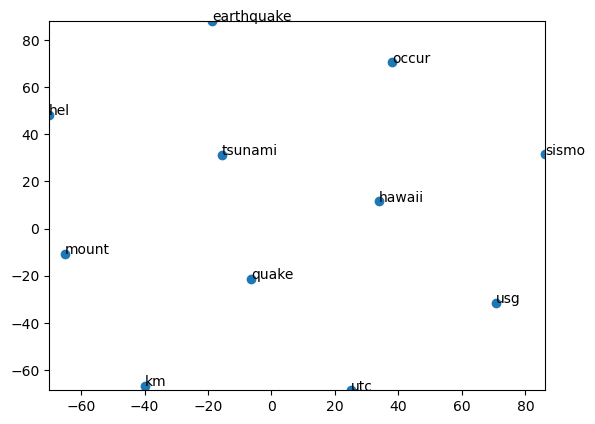

In [14]:
display_closestwords_tsnescatterplot(cbow_model, 'earthquake', 128)

/Users/luish/anaconda3/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


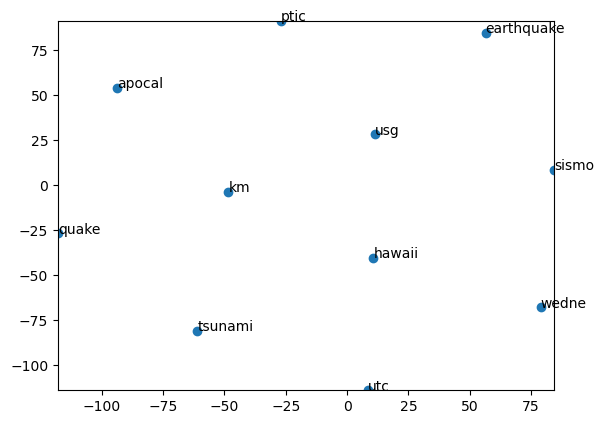

In [15]:
display_closestwords_tsnescatterplot(skipgram_model, 'earthquake', 128)

/Users/luish/anaconda3/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


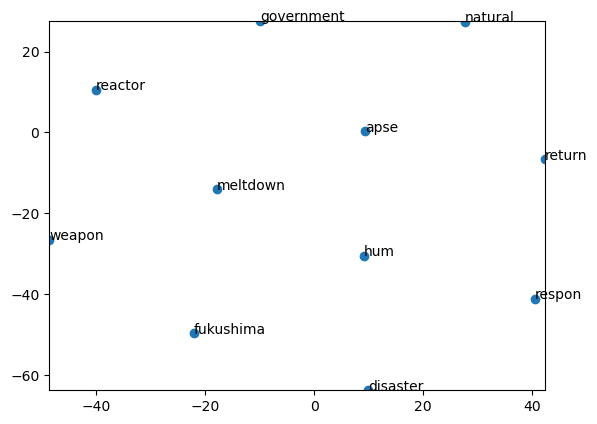

In [16]:
display_closestwords_tsnescatterplot(cbow_model, 'disaster', 128)

/Users/luish/anaconda3/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


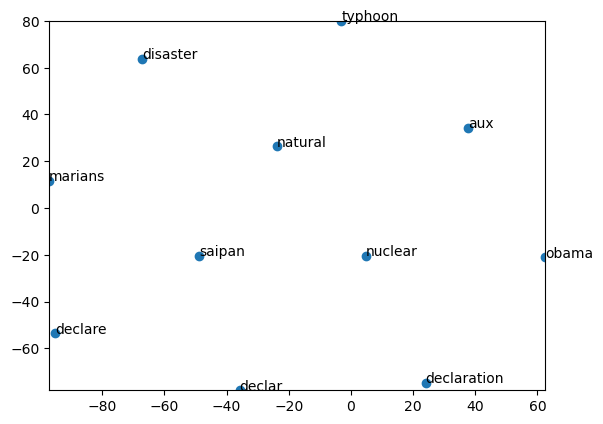

In [17]:
display_closestwords_tsnescatterplot(skipgram_model, 'disaster', 128)

# Loading and Testing our Pre-Trained Embeddings to the PyTorch's Embedding layer

In [18]:
# create embedding layer with pre-trained weights
pretrained_embeddings_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors))
# check weights of the pre-trained embedding layer
pretrained_embeddings_layer.weight

Parameter containing:
tensor([[ 0.1107,  0.0100,  0.1835,  ..., -0.0073, -0.0065,  0.0718],
        [-0.0907,  0.1056,  0.0091,  ..., -0.1857,  0.0093, -0.0928],
        [ 0.1838,  0.1627,  0.1268,  ...,  0.1276,  0.1674,  0.0796],
        ...,
        [ 0.0722, -0.1376,  0.4504,  ...,  0.0375,  0.1965, -0.3061],
        [ 0.3185, -0.1236,  0.5972,  ..., -0.4047,  0.4040, -0.0137],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [19]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')
TrainTweetsDataset[0]

(tensor([  31,   62,  850,  432, 2265,  425,  452, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899]),
 tensor([1.]))

In [20]:
sequence = TrainTweetsDataset[0][0]
sequence_embeddings = pretrained_embeddings_layer(sequence)

print('Embedding of the first token:          {}'.format(sequence_embeddings[0]))
print('Embedding of the second token:         {}'.format(sequence_embeddings[1]))
print('Embedding of the third token:          {}'.format(sequence_embeddings[2]))
print('Embedding of the fourth token:         {}'.format(sequence_embeddings[3]))
print('Embedding of the fifth token:          {}'.format(sequence_embeddings[4]))
print('Embedding of the sixth token:          {}'.format(sequence_embeddings[5]))
print('Embedding of the twenty-fifth token:   {}'.format(sequence_embeddings[24]))
print('Embedding of the fortieth token:       {}'.format(sequence_embeddings[39]))
print('Embedding of the fiftieth token:       {}'.format(sequence_embeddings[49]))

Embedding of the first token:          tensor([-0.0584, -0.1325,  0.2763,  0.0411,  0.1023, -0.2795, -0.1006, -0.0382,
         0.0530,  0.1430, -0.1381, -0.0954, -0.1852, -0.2394,  0.1891, -0.2619,
        -0.2148, -0.0981, -0.1525,  0.1907,  0.0797,  0.2206,  0.0897, -0.1197,
        -0.2174,  0.0486, -0.3808,  0.0556, -0.3051,  0.0961, -0.0696,  0.2446,
        -0.2114,  0.0663, -0.2915, -0.2220, -0.2581,  0.1359,  0.1064, -0.0462,
        -0.1436, -0.1251, -0.0208, -0.0568,  0.0380,  0.2784, -0.2524, -0.0874,
        -0.0061, -0.2194,  0.0831, -0.2845,  0.4720, -0.0719, -0.2550,  0.0346,
        -0.1767, -0.1141, -0.1466,  0.1237,  0.0613,  0.1274,  0.0478, -0.0102,
         0.0959, -0.3094, -0.0135, -0.0723,  0.0670,  0.0620, -0.1862, -0.0347,
        -0.1016,  0.0994,  0.0954, -0.2435, -0.0096, -0.0108, -0.0274, -0.1687,
        -0.2778, -0.2421,  0.0208, -0.1297,  0.0503,  0.2207,  0.1268,  0.0010,
         0.0123,  0.4661, -0.2677,  0.0054, -0.2734, -0.0696, -0.3704, -0.1983,
 

# Training LSTM Network with Custom Pre-trained Word2Vec Embeddings

In [21]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')

In [22]:
# Create a dataloade for the training dataset
TrainDataLoader = torch.utils.data.DataLoader(dataset = TrainTweetsDataset, batch_size = 256, shuffle = True)

In [23]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model, 
                                  hidden_size = 128, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 0.001)

Device: mps


In [24]:
train_losses, train_accs = train(customPreTrainedLSTM, TrainDataLoader, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


  0%|          | 0/30 [00:00<?, ?it/s]

Loss = 0.6912  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Training Cross-Entropy Loss = 0.6855
Training Accuracy = 57.03%
Epoch 2/8
======== Training phase ========


Loss = 0.6917  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.27it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Epoch 3/8
======== Training phase ========


Loss = 0.6712  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 46.15it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Epoch 4/8
======== Training phase ========


Loss = 0.6871  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.99it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Epoch 5/8
======== Training phase ========


Loss = 0.6969  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 46.61it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Epoch 6/8
======== Training phase ========


Loss = 0.6710  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 46.03it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Epoch 7/8
======== Training phase ========


Loss = 0.6847  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.73it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Epoch 8/8
======== Training phase ========


Loss = 0.6725  |  Accuracy = 57.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 46.29it/s]

Training Cross-Entropy Loss = 0.6831
Training Accuracy = 57.03%


In [25]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 128, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 0.001)

Device: mps


In [26]:
train_losses, train_accs = train(customPreTrainedLSTM_Attention, TrainDataLoader, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.4744  |  Accuracy = 61.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.61it/s]


Training Cross-Entropy Loss = 0.6131
Training Accuracy = 61.75%
Epoch 2/8
======== Training phase ========


Loss = 0.5180  |  Accuracy = 77.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 44.98it/s]


Training Cross-Entropy Loss = 0.4648
Training Accuracy = 77.91%
Epoch 3/8
======== Training phase ========


Loss = 0.4156  |  Accuracy = 80.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.54it/s]


Training Cross-Entropy Loss = 0.4210
Training Accuracy = 80.28%
Epoch 4/8
======== Training phase ========


Loss = 0.3976  |  Accuracy = 82.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.13it/s]


Training Cross-Entropy Loss = 0.3847
Training Accuracy = 82.66%
Epoch 5/8
======== Training phase ========


Loss = 0.3614  |  Accuracy = 84.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.62it/s]


Training Cross-Entropy Loss = 0.3457
Training Accuracy = 84.16%
Epoch 6/8
======== Training phase ========


Loss = 0.3172  |  Accuracy = 87.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.68it/s]


Training Cross-Entropy Loss = 0.2985
Training Accuracy = 87.11%
Epoch 7/8
======== Training phase ========


Loss = 0.3448  |  Accuracy = 89.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 44.49it/s]


Training Cross-Entropy Loss = 0.2602
Training Accuracy = 89.27%
Epoch 8/8
======== Training phase ========


Loss = 0.2500  |  Accuracy = 90.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 45.36it/s]


Training Cross-Entropy Loss = 0.2219
Training Accuracy = 90.40%
